## Sentiment Analysis of Patient Reviews
### Overview
Experiment using jupyter notebook to run some sentiment analysis. Crawl review data from NSH website manually.

In [1]:
#Download required ntlk packages and lib
import nltk
import matplotlib
nltk.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kjakka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kjakka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from collections import Counter
import re
import math
import html
import sklearn
import sklearn.metrics as metrics
from matplotlib import pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

%matplotlib inline

In [3]:
# Testing
#Sentences to try with vader
sentences = ["VADER is smart, handsome, and funny.",
             "Data Scientists are sexy!",
             "The room was dirty and small",
             "They had excellent facilities!",
             "This hotel is the worst hotel in the city"]
sid = SentimentIntensityAnalyzer()
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
         print('{0}: {1}, '.format(k, ss[k]), end='')
    print('\n')

VADER is smart, handsome, and funny.
compound: 0.8316, neg: 0.0, neu: 0.254, pos: 0.746, 

Data Scientists are sexy!
compound: 0.5707, neg: 0.0, neu: 0.448, pos: 0.552, 

The room was dirty and small
compound: -0.4404, neg: 0.367, neu: 0.633, pos: 0.0, 

They had excellent facilities!
compound: 0.6114, neg: 0.0, neu: 0.429, pos: 0.571, 

This hotel is the worst hotel in the city
compound: -0.6249, neg: 0.339, neu: 0.661, pos: 0.0, 



In [4]:
revframe = pd.read_csv('Riverside.txt', sep='\t', lineterminator='\n')
revframe.columns = ['Date','Stars','Title','Review']
revframe.head()

,Date,Stars,Title,Review
0,03-May-2019,2,Surely you should be listened too and made to ...,Both my wife and I are patients presently regi...
1,27-February-2019,1,Appalling customer service,I'd love to be emailing the bellow to the prac...
2,20-January-2019,1,unable to get appointment,Have attended on several occasions and have ne...
3,26-July-2018,3,Impossible to get through,Don't try and ring them - there's usually one ...
4,12-June-2018,2,Not able to get appoitment due to extremly rud...,We are new to the town and wanted to register ...


In [5]:
sid = SentimentIntensityAnalyzer()
vaderScores = []
gtScores = []
for rn, review in enumerate(revframe['Review']):
    scores = sid.polarity_scores(review)
    vaderScores.append(scores['compound'])
revframe = revframe.assign(vaderScore = vaderScores)

for rn, stars in enumerate(revframe['Stars']):
    if stars >= 3:
        gtScores.append('positive')
    else:
        gtScores.append('negative')
revframe = revframe.assign(groundTruth = gtScores)
revframe.head()

,Date,Stars,Title,Review,vaderScore,groundTruth
0,03-May-2019,2,Surely you should be listened too and made to ...,Both my wife and I are patients presently regi...,0.9060,negative
1,27-February-2019,1,Appalling customer service,I'd love to be emailing the bellow to the prac...,0.6485,negative
2,20-January-2019,1,unable to get appointment,Have attended on several occasions and have ne...,-0.9398,negative
3,26-July-2018,3,Impossible to get through,Don't try and ring them - there's usually one ...,0.4753,positive
4,12-June-2018,2,Not able to get appoitment due to extremly rud...,We are new to the town and wanted to register ...,0.5837,negative


In [6]:
ratingByStars = revframe.sort_values('Stars', ascending=False)
ratingByStars.head(10)

,Date,Stars,Title,Review,vaderScore,groundTruth
9,24-January-2018,5,Excellent Customer Service - Medical Secretary,I phoned the medical secretary at Riverside Pr...,0.9897,positive
7,02-January-2018,5,A good team,My wife and I have been with Riverside for som...,0.6359,positive
16,10-July-2017,5,Thank you Riverside,I needed to use the services at Riverside last...,0.9740,positive
13,09-October-2017,5,Blood test,I had an appointment this morning to have a bl...,-0.9012,positive
11,05-December-2017,5,Thank you Riverside,I am new to the Practice and felt that the way...,0.8687,positive
8,19-January-2018,5,Riverside practice feedback,I am truly happy with the service provided at ...,0.9875,positive
17,27-June-2017,5,Well looked after,I visited the doctor today who was kind when I...,0.4911,positive
6,26-July-2018,5,they always sort me out and i cannot praise th...,I have enjoyed an excellent relationship with ...,0.3818,positive
3,26-July-2018,3,Impossible to get through,Don't try and ring them - there's usually one ...,0.4753,positive
5,06-July-2018,2,Reception staff rarely nice or helpful,Have been at the surgery for years and always ...,-0.4354,negative


In [7]:
ratingByVader = revframe.sort_values('vaderScore', ascending=False)
ratingByVader.head(10)

,Date,Stars,Title,Review,vaderScore,groundTruth
9,24-January-2018,5,Excellent Customer Service - Medical Secretary,I phoned the medical secretary at Riverside Pr...,0.9897,positive
8,19-January-2018,5,Riverside practice feedback,I am truly happy with the service provided at ...,0.9875,positive
16,10-July-2017,5,Thank you Riverside,I needed to use the services at Riverside last...,0.9740,positive
15,07-October-2017,1,my experience with this practice is .............,I find the practice as a whole the shambles. y...,0.9490,negative
0,03-May-2019,2,Surely you should be listened too and made to ...,Both my wife and I are patients presently regi...,0.9060,negative
11,05-December-2017,5,Thank you Riverside,I am new to the Practice and felt that the way...,0.8687,positive
12,29-December-2017,1,Quite a let down,My Wife had to attend this practice only yeste...,0.8501,negative
1,27-February-2019,1,Appalling customer service,I'd love to be emailing the bellow to the prac...,0.6485,negative
7,02-January-2018,5,A good team,My wife and I have been with Riverside for som...,0.6359,positive
4,12-June-2018,2,Not able to get appoitment due to extremly rud...,We are new to the town and wanted to register ...,0.5837,negative


In [8]:
def get_topk_ngram(df, ngram_range=(1,1), k=None, stopwords=True, with_count=False):
    '''
    Extract the most frequently occurred words in countvector
    '''
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=k)
    countvector = vectorizer.fit_transform(df['Review'])

    # Get topk occurred ngrams
    topk_words = []
    sortedindices = countvector.toarray().sum(axis=0).argsort()[::-1][:k]
    counts = countvector.toarray().sum(axis=0)
    
    for i in sortedindices:
        word = vectorizer.get_feature_names()[i]
        
        if with_count:
            count = counts[i]
            topk_words.append((word, count))
        else:
            topk_words.append(word)
            
    return topk_words

topkPos = get_topk_ngram(revframe.loc[revframe['Stars']>=3], ngram_range=(1,1), k=10, with_count=True)
print("The most frequently occured top 10 words in positive reviews")
pprint(pd.DataFrame(topkPos, columns=['Word', 'Count']))

topkNeg = get_topk_ngram(revframe.loc[revframe['Stars']<3], ngram_range=(1,1), k=10, with_count=True)
print("The most frequently occured top 10 words in negative reviews")
pprint(pd.DataFrame(topkNeg, columns=['Word', 'Count']))

topkPos_bigram = get_topk_ngram(revframe.loc[revframe['Stars']>=3], ngram_range=(2,2), k=10, with_count=True)
print("The most frequently occured top 10 bigrams in positive reviews")
pprint(pd.DataFrame(topkPos_bigram, columns=['Bigram', 'Count']))

topkNeg_bigram = get_topk_ngram(revframe.loc[revframe['Stars']<3], ngram_range=(2,2), k=10, with_count=True)
print("The most frequently occured top 10 bigrams in negative reviews")
pprint(pd.DataFrame(topkNeg_bigram, columns=['Bigram', 'Count']))

The most frequently occured top 10 words in positive reviews
          Word  Count
0  appointment      7
1      surgery      6
2      helpful      6
3      service      5
4         good      5
5       doctor      5
6    riverside      4
7         know      4
8          ill      4
9        blood      4
The most frequently occured top 10 words in negative reviews
           Word  Count
0   appointment     13
1      practice     10
2        doctor      8
3          wife      7
4  receptionist      6
5       surgery      5
6         staff      5
7        trying      4
8     riverside      4
9     reception      4
The most frequently occured top 10 bigrams in positive reviews
                  Bigram  Count
0        reception staff      3
1     separate occasions      2
2      referred hospital      2
3      medical secretary      2
4     secretary attended      1
5             saw doctor      1
6      receptionist sure      1
7  receptionist advanced      1
8          received good      1


In [9]:
# positive = 1 / negative = 0
gtScore = []
for i in range(len(revframe)):
    if revframe['Stars'][i] >= 3:
        gtScore.append(1)
    else:
        gtScore.append(0)
        

# let's calculate Mutual Information for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(revframe['Review'])
densevector = np.array(countvector.todense())
    
# miScore_unigram = pd.DataFrame(data = {'word': vectorizer.get_feature_names(),
#              'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]})

miScore_unigram = pd.DataFrame(data =
                               {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]}
                              , index = vectorizer.get_feature_names())

# Bigram version
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(revframe['Review'])
densevector = np.array(countvector.todense())
miScore_bigram = pd.DataFrame(data =
                    {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]},
                    index = vectorizer.get_feature_names())  

miScore_unigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Unigram')
miScore_unigram.head(10)

Mutual Information - Unigram


,MI Score
appointment,0.212171
helpful,0.194680
feel,0.161996
great,0.161996
away,0.132304
work,0.132304
past,0.132304
professional,0.132304
good,0.118617
surgery,0.117663


In [10]:
miScore_bigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Bigram')
miScore_bigram.head(10)

Mutual Information - Bigram


,MI Score
appointment doctors,0.083979
referred hospital,0.083979
point contact,0.083979
online appointment,0.077016
telling doc,0.040143
straight appointment,0.040143
staff stress,0.040143
staff riverside,0.040143
staff properly,0.040143
staff make,0.040143


In [11]:
def getPMI_ngram(df, gt, ngram_range=(1,1), max_features=500):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    countvector = vectorizer.fit_transform(df)
    densevector = np.array(countvector.todense())
    
    px = sum(df['groundTruth'] == gt) / len(df)
    pmis = []
    
    for i in range(max_features):
        py = sum(densevector[:,i] == 1) / len(df)
        pxy = len(df[(df['groundTruth'] == gt) & (densevector[:,i] == 1)]) / len(df)
        
        if pxy == 0:
            pmi = math.log10((pxy + 0.0001) / (px * py))
        else:
            pmi = math.log10(pxy / (px * py))
            
        pmis.append(pmi)
        
    pmis = pd.DataFrame(data = {'pmi' + gt: pmis}, index = vectorizer.get_feature_names())
    return pmis.sort_values('pmi' + gt, ascending=False)

In [12]:
# pmiPos_unigram = getPMI_ngram(revframe, 'positive')
# print('PMI for positive reviews - Unigram')
# pmiPos_unigram.head()

# pmiNeg_unigram = getPMI_ngram(revframe, 'negative')
# print('PMI for negative reviews - Unigram')
# pmiNeg_unigram.head()

# pmiPos_bigram = getPMI_ngram(revframe, 'positive', ngram_range=(2,2))
# print('PMI for positive reviews - Bigram')
# pmiPos_bigram.head()

# pmiNeg_bigram = getPMI_ngram(revframe, 'negative', ngram_range=(2,2))
# print('PMI for negative reviews - Bigram')
# pmiNeg_bigram.head()

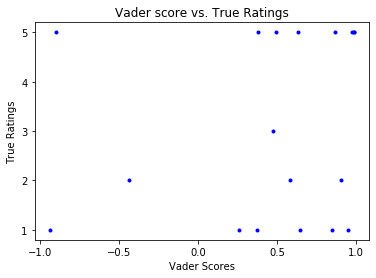

In [13]:
y = revframe['Stars'].values
x = revframe['vaderScore'].values
plt.title('Vader score vs. True Ratings')
plt.xlabel('Vader Scores')
plt.ylabel('True Ratings')
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([1,2,3,4,5])
plt.plot(x, y, "o", ms=3, color='b')
plt.show()

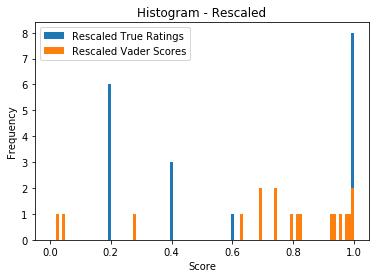

In [14]:
#Overlayed Histogram for GT rating and VD score
#Just for demonstrating, I am dividing the rating score by 5
x = [revframe['Stars'].values / 5]
y = [(revframe['vaderScore'].values + 1 )/ 2]
bins = np.linspace(0, 1, 100)
plt.hist(x, bins, label='Rescaled True Ratings')
plt.hist(y, bins, label='Rescaled Vader Scores')
plt.title('Histogram - Rescaled')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

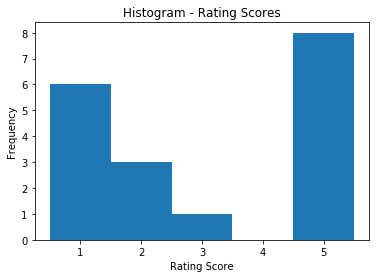

In [15]:
plt.xlabel('Rating Score')
revframe['Stars'].plot(kind='hist', title='Histogram - Rating Scores',
                            bins=np.arange(1,7)-0.5)
plt.show()

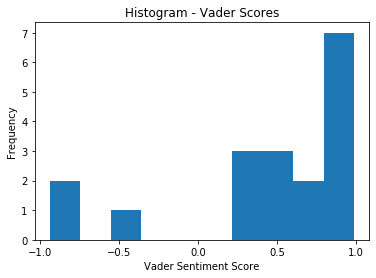

In [16]:
plt.xlabel('Vader Sentiment Score')
revframe['vaderScore'].plot(kind='hist', title='Histogram - Vader Scores', 
                           xticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()